In [1]:
#Imports
import re
import requests
import numpy as np
import pandas as pd
from pandas_gbq import read_gbq
import nltk
from bs4 import BeautifulSoup

In [3]:
# Set up plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (12, 8), 'xtick.labelsize': 14, 'ytick.labelsize': 14})
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind', 8))

In [4]:
#Obtain stopwords list
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nl

[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     /home/jbandlow/nltk_data...
[nltk_data]    |   Package verbnet is already up-to-date!
[nltk_data]    | Downloading package webtext to
[nltk_data]    |     /home/jbandlow/nltk_data...


True

In [5]:
#Set up query
projectid = 'jrb-gcp-personal'
# If running locally, use a full path to this file.
private_key = '/home/jbandlow/Downloads/jrb-gcp-personal-9e21aa7b9578.json'
configuration = {
   'query': {
     'useLegacySql': False
   }
}
query = r'''
select 
    timestamp,
    text,
    parent,
    ranking,
    id,
    `by` # "by" is a keyword, so must be enclosed by backticks
from `bigquery-public-data.hacker_news.full` 
where 
  type = 'comment' and 
  (
     regexp_contains(lower(text), r'[ \$]btc') or
     regexp_contains(lower(text), r'bitcoin') or
     regexp_contains(lower(text), r'bit coin')
  )
'''

In [6]:
#Obtain Bitcoin related comments
df = read_gbq(query, projectid, private_key=private_key, configuration=configuration)

In [8]:
# Clean the html
df['clean_text'] = df.text.apply(lambda _: BeautifulSoup(_, 'html.parser').get_text())

Lemmatizing code, not used for now:

```
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
pos_dict = {
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'J': wordnet.ADJ,
    'R': wordnet.ADV
}
def lemmatize(text_list):
    tagged_list = nltk.pos_tag(text_list)
    out = []
    for word, pos in tagged_list:
        simple_pos = pos_dict.get(pos[0])
        if simple_pos:
            out.append(lemmatizer.lemmatize(word, simple_pos))
    return out
```

In [9]:
"""
If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
"""
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df['compound_sentiment'] = df.clean_text.apply(lambda _: sid.polarity_scores(_)['compound'])

/home/jbandlow/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


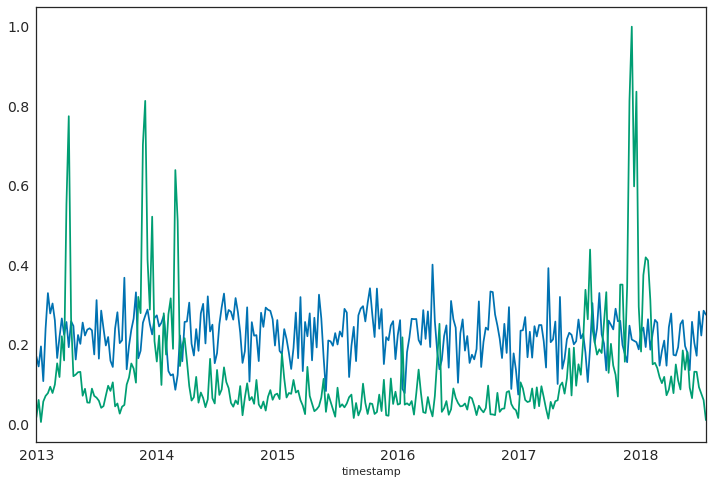

In [10]:
PERIOD = 'W'
START = '2013-01-01'
grp = df.groupby(df.timestamp.dt.to_period(PERIOD))

grp.compound_sentiment.mean()[START:].plot()
(grp.timestamp.count()[START:] / grp.timestamp.count()[START:].max()).plot()

In [11]:
params = {
    'start': START,
    'end': '2018-06-01'
}
url = 'https://api.coindesk.com/v1/bpi/historical/close.json'
r = requests.get(url, params)

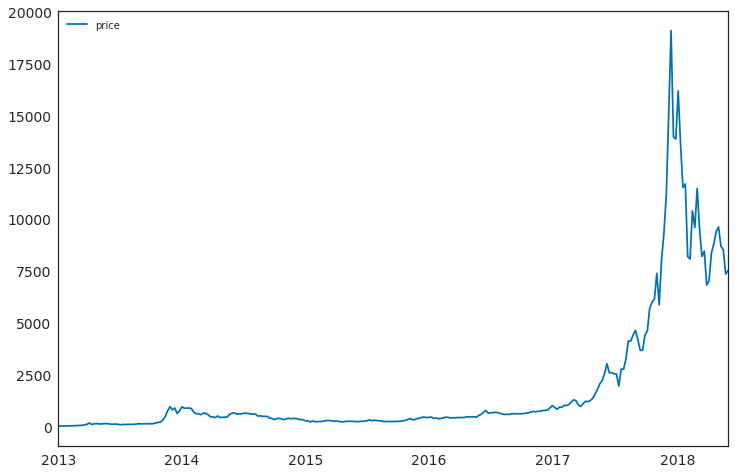

In [13]:
price = pd.DataFrame(r.json()['bpi'], index=['price']).T
price.index = pd.DatetimeIndex(price.index)
wprice = price.groupby(lambda _: _.to_period('W')).last()
wprice.plot()

In [52]:
price_delta = wprice.div(wprice.shift(1)) - 1
normalized_sentiment = grp.compound_sentiment.mean() - grp.compound_sentiment.mean().mean()
data = pd.DataFrame(
    {'delta': price_delta.price, 'sentiment': normalized_sentiment},
    index=price_delta.index
)

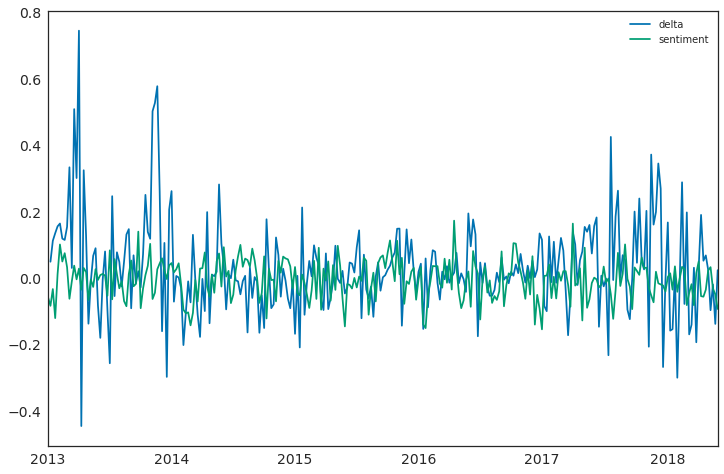

In [53]:
data.plot()